### Intro
This part is mostly going to follow Michael's notebook as is, we will replace matplotlib with plotly as I like plotly more. Anyway, let's load the data and get cracking

### Imports and Settings

In [24]:
# Internals

# Externals
from rich import print

# Analytics
import pandas as pd
from sklearn.datasets import fetch_openml
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Project specific
import missingno

pd.options.plotting.backend = "plotly"


##### Load dataset

In [2]:
dataset = fetch_openml(data_id=42803, as_frame=True)
df_X = dataset["frame"]
df_X


,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1.0,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3.0,5.0,1.0,0.0,0.0,2.0,0.0,NaN,NaN
1,201501BS70002,1.0,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3.0,9.0,9.0,0.0,0.0,2.0,0.0,1.0,3.0
2,201501BS70004,1.0,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3.0,1.0,3.0,0.0,0.0,2.0,0.0,1.0,6.0
3,201501BS70005,1.0,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3.0,5.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0
4,201501BS70008,1.0,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13.0,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3.0,0.0,0.0,2.0,0.0,0.0,9.0,1.0,NaN
363239,2015984141415,13.0,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0
363240,2015984141415,13.0,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0,5.0
363241,2015984141415,13.0,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,NaN


## Structural investigation

In [3]:
# Dataset shape
print(f"{df_X.shape=}")


df_X.shape=(363243, 67)

In [4]:
print(pd.value_counts(df_X.dtypes))


float64    61
object      6
dtype: int64

#### 1.1 Structure of non-numerical features

In [5]:
df_X.select_dtypes(exclude="number").head()


,Accident_Index,Sex_of_Driver,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
0,201501BS70001,1.0,12/01/2015,18:45,E09000020,E01002825
1,201501BS70002,1.0,12/01/2015,07:50,E09000020,E01002820
2,201501BS70004,1.0,12/01/2015,18:08,E09000020,E01002833
3,201501BS70005,1.0,13/01/2015,07:40,E09000020,E01002874
4,201501BS70008,1.0,09/01/2015,07:30,E09000020,E01002814


In [6]:
# Sex_of_Driver is stored of non-numerical feature for unknown reasons so let's fix that
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")


In [7]:
df_X.describe(exclude="number")


,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,363243,319866,319822,319866,298758
unique,140056,365,1439,204,25979
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2972,8457,1456


#### 1.2 Structure of numerical features

In [8]:
unique_values = df_X.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(title="Unique values per numerical feature", log_y=True)


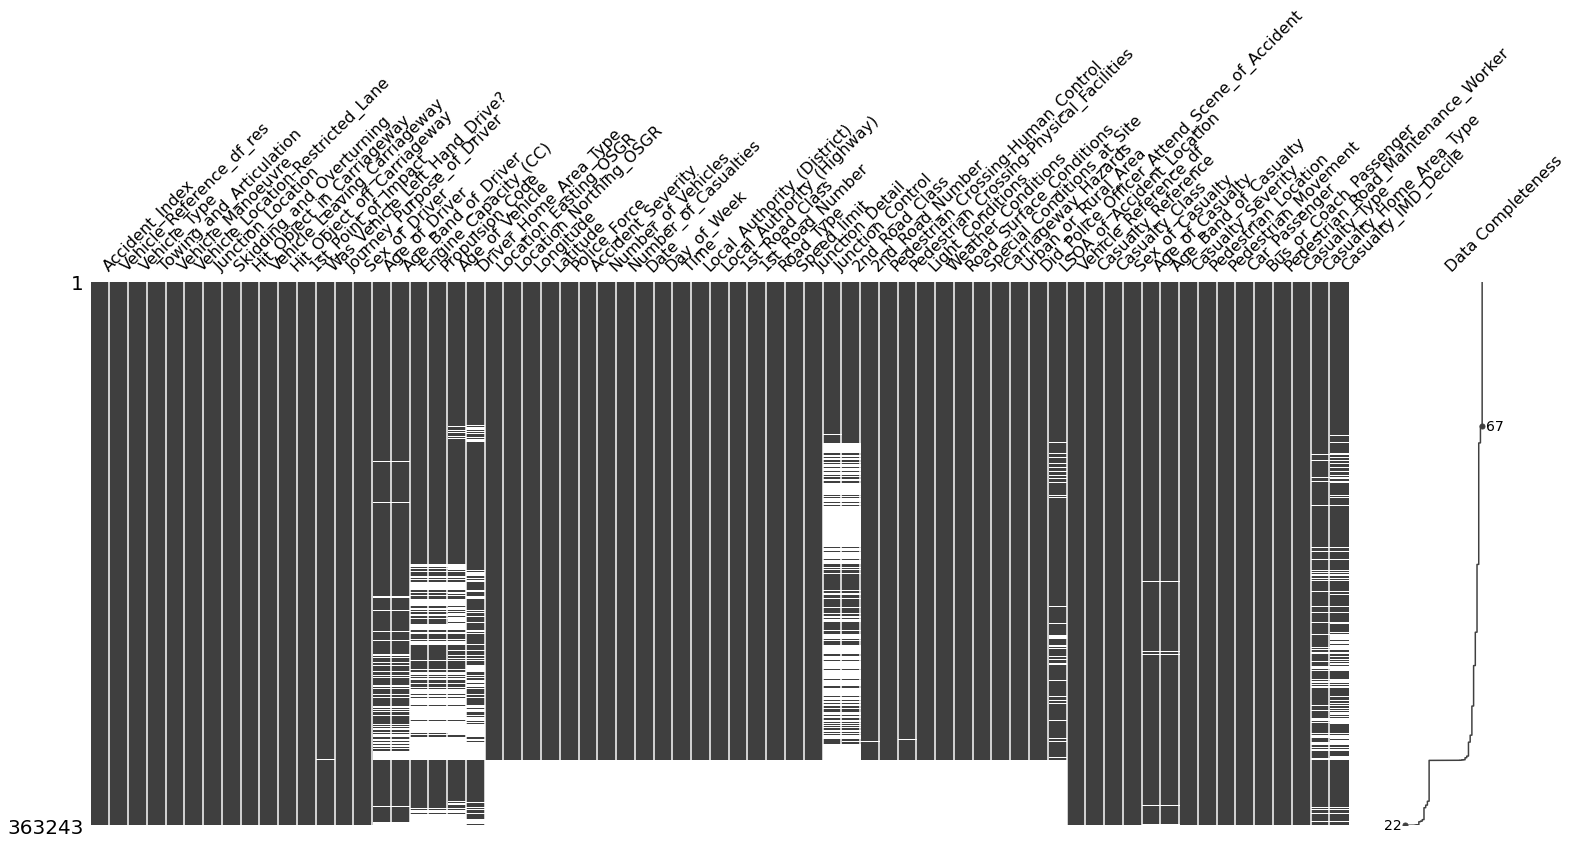

In [9]:
missingno.matrix(df_X, labels=True, sort="descending");

In [10]:
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.80, axis=0).reset_index(drop=True)
print(f"{df_X.shape=}")

df_X.shape=(319795, 67)

In [13]:
df_X.isna().mean().sort_values().plot(
    kind="bar",
    title="Percentage of missing values per feature",
)


In [14]:
# A bunch of features have a load of missing values so let's throw them out
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)
print(f"{df_X.shape=}")

df_X.shape=(319795, 60)

#### 2.3.1. Numerical features

In [16]:
pd.options.plotting.backend = "matplotlib"

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplo

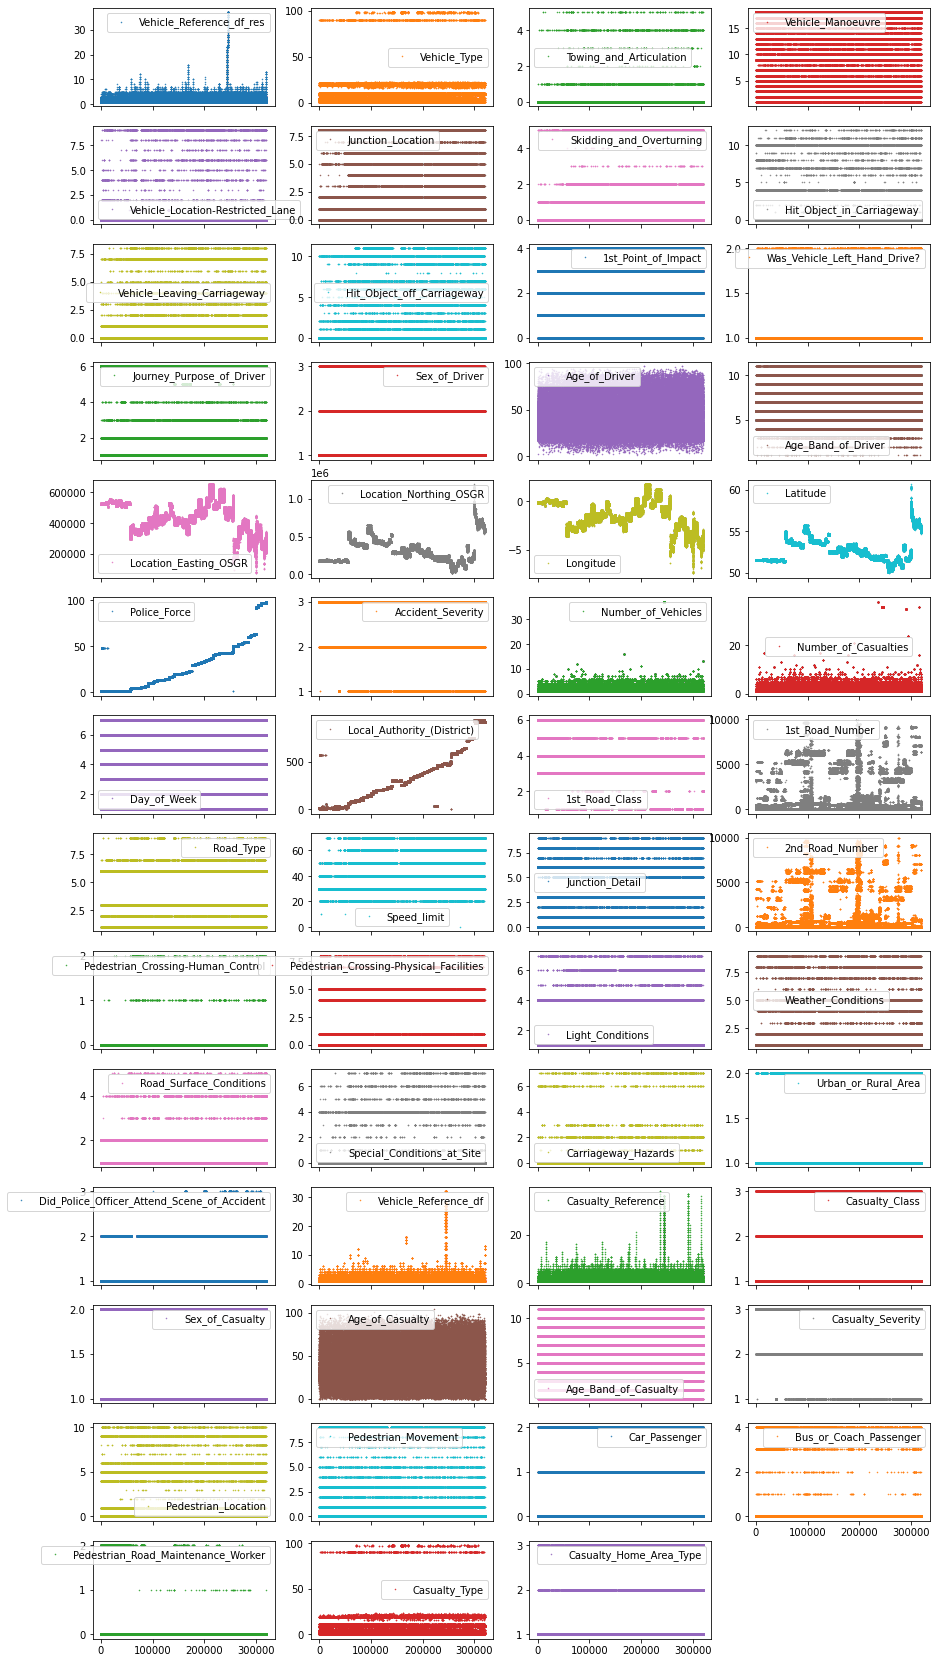

In [17]:
df_X.plot(
    lw=0, marker=".", subplots=True, layout=(-1, 4), figsize=(15, 30), markersize=1
)

<AxesSubplot:>

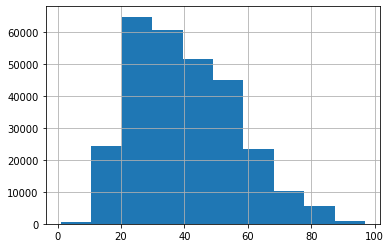

In [19]:
df_X.Age_of_Driver.hist()
# I am surprised there are so many drivers before 20

In [20]:
df_X.describe(exclude=["number", "datetime"])

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,319795,319795,319751,319795,298698
unique,123646,365,1439,204,25977
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2969,8457,1456


In [30]:
fig = make_subplots(rows=3, cols=1)
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])

for i, column in enumerate(df_non_numerical.columns):
    fig.add_trace(
        go.Scatter(
            x=df_non_numerical[column].value_counts().index,
            y=df_non_numerical[column].value_counts(),
        ),
        row=i+1,
        col=1,
    )
fig.show()


In [27]:
df_non_numerical[col].value_counts().index

Index(['201543P296025', '2015621500156', '201597AC70404', '2015984141415',
       '201522D501706', '201501RY10259', '201542I309809', '2015160C06511',
       '20154100T3095', '2015300013662',
       ...
       '2015215000525', '2015215000531', '2015215000561', '2015215000581',
       '2015215000589', '2015215000592', '2015215000615', '2015215000638',
       '2015215000639', '201520W033415'],
      dtype='object', length=123646)